# Ciruculation Insights

This notebook will begin to explore the circulation data to find how it aligns with the WIM data. In particular it will look into the following distances between cars and trucks, the headway and the likelihood that a car is between trucks. This is in addition to general trends looked into by the data.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
#import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from workalendar.europe import Switzerland
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from multiprocessing import cpu_count
#from joblib import Parallel
#from joblib import delayed


sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.rc('figure',figsize=(12,8))

In [4]:
station = 137
year = 2017

In [5]:
df_all = pd.read_pickle('{}/{}_circ.pkl'.format(station, year))

In [6]:
df_all.SwissT.value_counts()

3     14347974
5      2481441
10      672291
2       544649
8       410383
9       204580
1       116872
4        97786
6        81533
7        45669
0           21
35           1
17           1
16           1
Name: SwissT, dtype: int64

In [7]:
df_all.head()

,z,Lane,Dir,Headway,IVT,Speed,Length,SwissT,Time,Date,index
0,0.0,5,1,99.9,99.9,109.0,384.0,3,0.020564,2017-01-01 00:01:14.003,0
1,0.0,2,1,99.9,99.9,110.0,518.0,3,0.023911,2017-01-01 00:01:26.008,1
2,0.0,5,1,13.9,13.8,112.0,379.0,3,0.024450,2017-01-01 00:01:28.002,2
3,0.0,5,1,0.6,0.5,115.0,448.0,3,0.024636,2017-01-01 00:01:28.069,3
4,0.0,5,1,7.5,7.4,116.0,426.0,3,0.026739,2017-01-01 00:01:36.026,4


In [8]:
heavy = [1, 8, 9, 10]
light = range(2, 8)

In [9]:
#Filter for the slow lanes
df_all = df_all[df_all.Lane == 5] #Change for only single lane

In [10]:
df_light = df_all[df_all['SwissT'].isin(light)]

In [11]:
df_heavy = df_all[df_all['SwissT'].isin(heavy)]

In [12]:
def reindex_series(df):
    df['DateHour'] = df.Date.dt.round('H')
    df = df.set_index(df.DateHour)
    new_idx = pd.date_range(df.index[0].date(), df.index[-1].date(), freq='H')
    df = df.drop(columns='DateHour')
    df = df.groupby('DateHour').Date.count()
    df = df.reindex(new_idx).groupby(lambda x: x.date()).filter(lambda x: x.isnull().sum() < 24)
    df = df.fillna(0)
    df = df.reindex(new_idx) #Remove the filter so that the Nans remain
    return df

In [13]:
def print_plots(series_values, lags, title):
    series_values.plot()
    plot_acf(series_values, lags=lags, title='Autocorrelation of {} Vehicles'.format(title))
    plt.show()
    plot_pacf(series_values, lags=lags, title='Partial Autocorrelation of {} Vehicles'.format(title))
    plt.show()

In [14]:
def train_test(df):
    df = df.to_frame()
    df.columns = ['HourCount']
    terms_df = add_fourier_terms(df, 0, 0, 0, 10) #Smallest AIC value 4 half, 5 day, 3 week, 4 year
    
    df['Date'] = pd.to_datetime(df.index.date)
    cal = Switzerland()
    swiss_hol = cal.holidays(2017) + cal.holidays(2018)
    hol_dates = []
    for date, name in swiss_hol:
        hol_dates.append(date)
    df['holiday'] = df['Date'].isin(hol_dates)
    df = df.drop(columns='Date')
    
    df = pd.concat([df, terms_df], axis=1)
    df['holiday'] = df.holiday.astype(float)
    test = df.tail(336)
    train = df.head(df.shape[0]-336)
    return test, train

In [15]:
df_light = reindex_series(df_light)

/home/pumford/.conda/envs/bridge/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
df_heavy = df_heavy.set_index('Date')
df_heavy = df_heavy.sort_index()

threshold_selector = df_heavy.IVT > 2.6 #defines a headway of threshold
groups = threshold_selector.cumsum()
df_heavy['Start']  = df_heavy.index.to_series()
df_heavy['End'] = df_heavy.index.to_series()
df_heavy_platoon = df_heavy.groupby(groups).agg({'Start':min, 'End':max, 'Length': lambda x: x.tolist(), 'IVT': lambda x: x.tolist()})

In [17]:
df_heavy_platoon['Date'] = df_heavy_platoon.Start

In [18]:
df_heavy = reindex_series(df_heavy_platoon)

In [19]:
df_all =reindex_series(df_all)

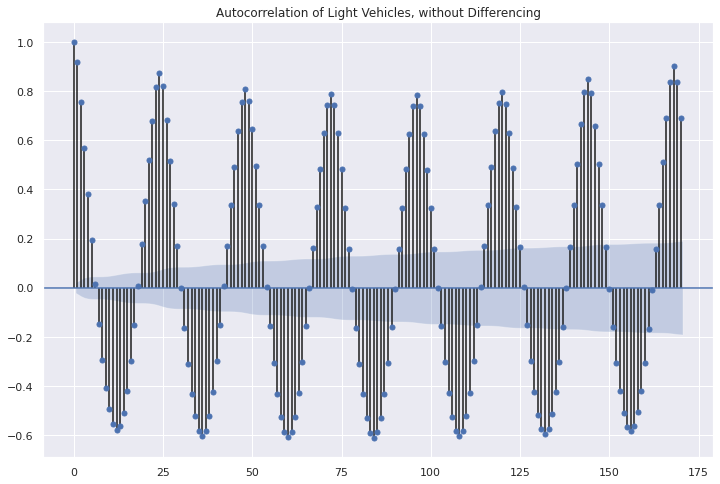

In [69]:
plot_acf(df_light, lags=170, title='Autocorrelation of Light Vehicles, without Differencing')
plt.show()

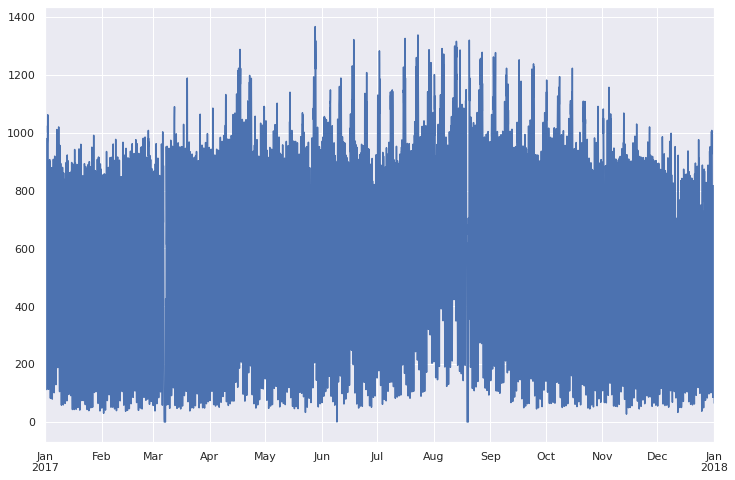

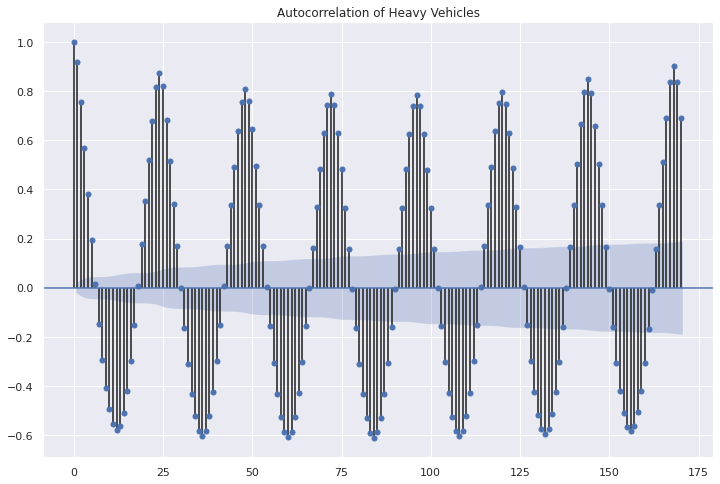

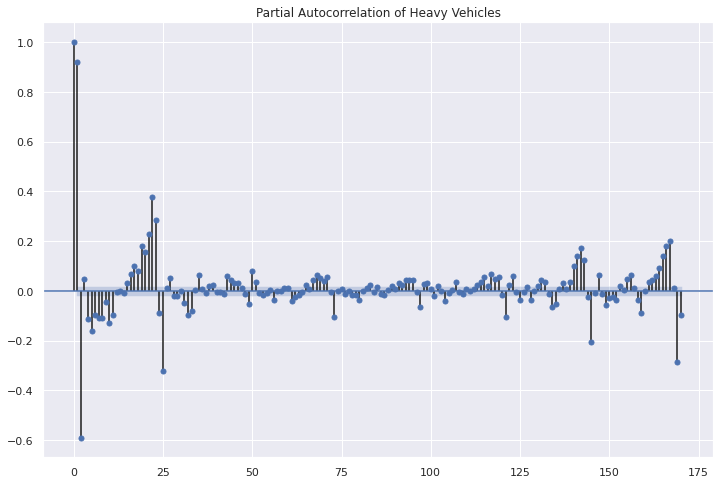

In [66]:
print_plots(df_light, 170, 'Heavy')

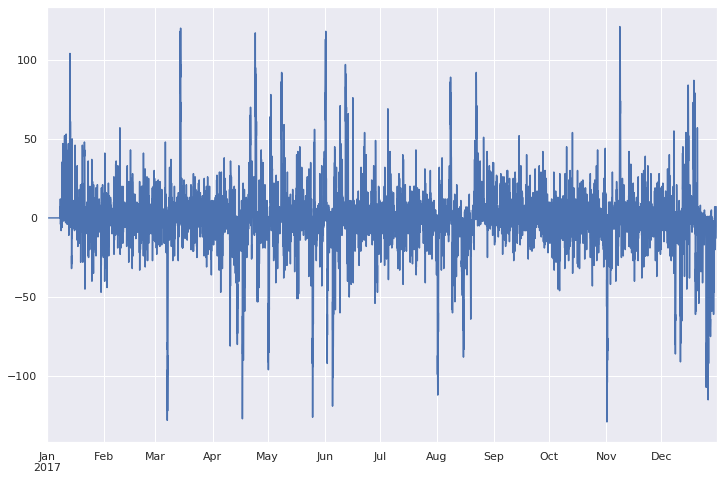

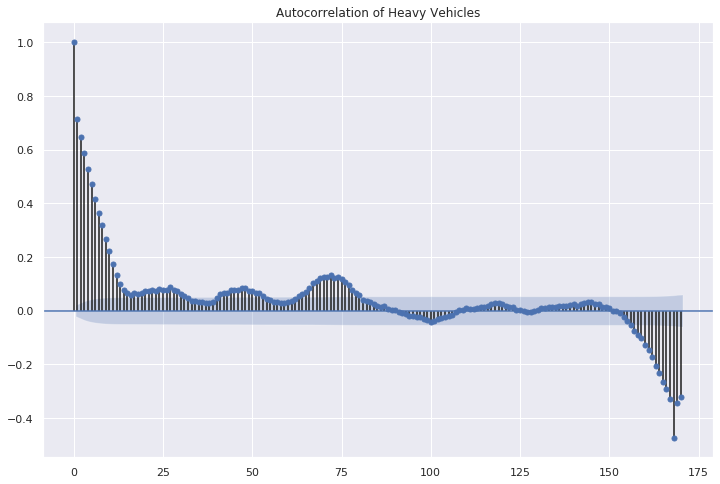

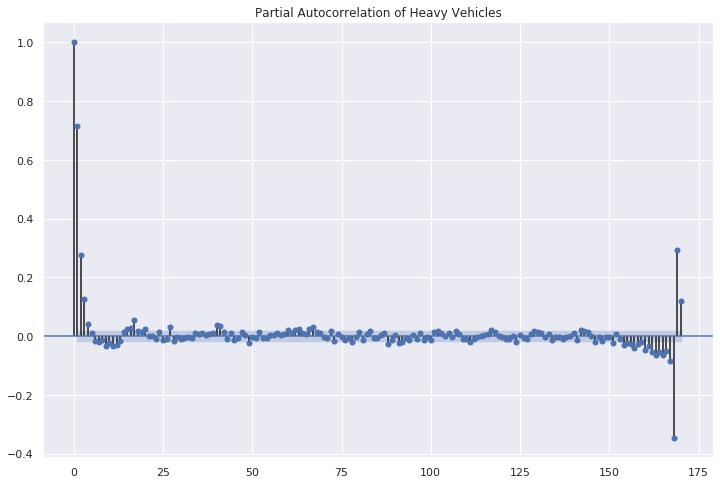

In [21]:
print_plots(df_heavy.diff(168).fillna(0), 170, 'Heavy')

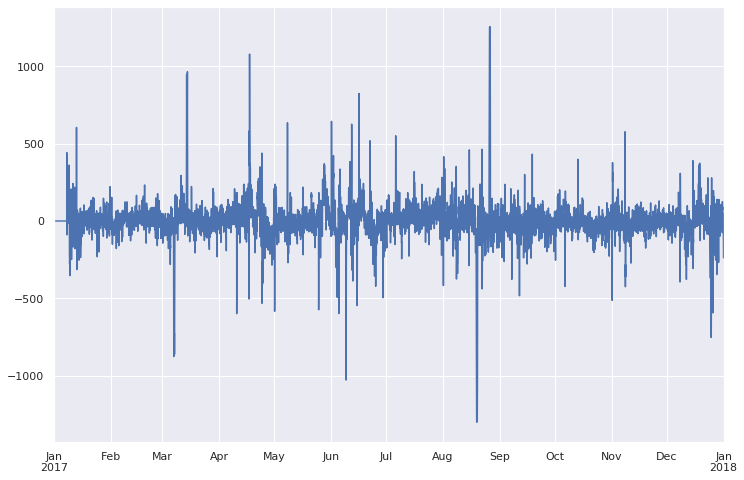

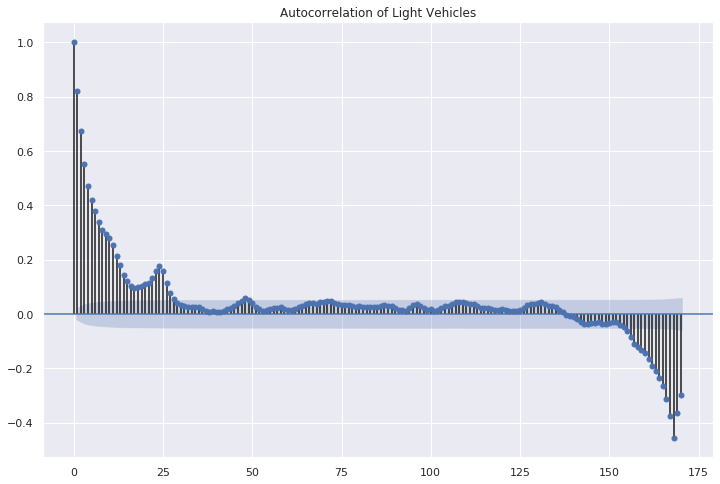

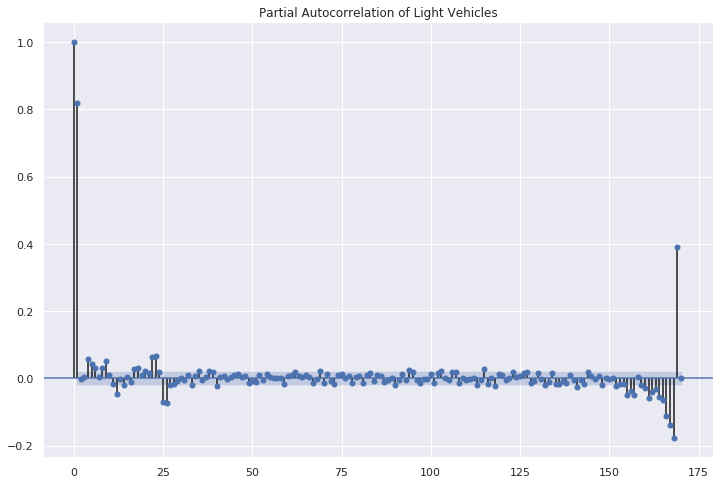

In [20]:
print_plots(df_light.diff(168).fillna(0), 170, 'Light')

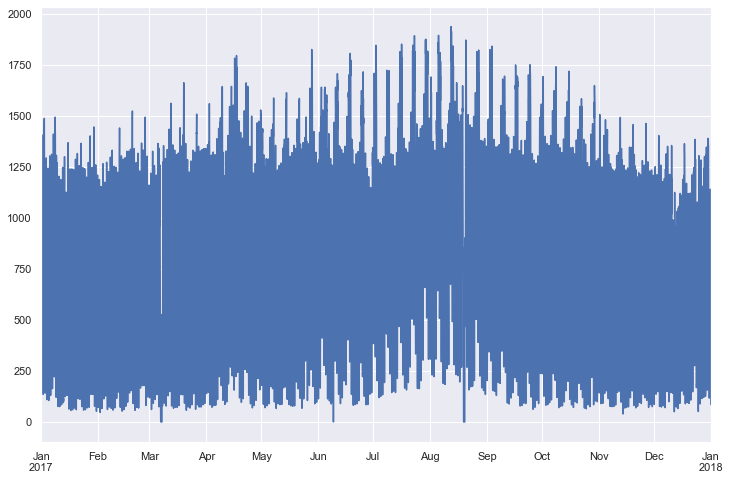

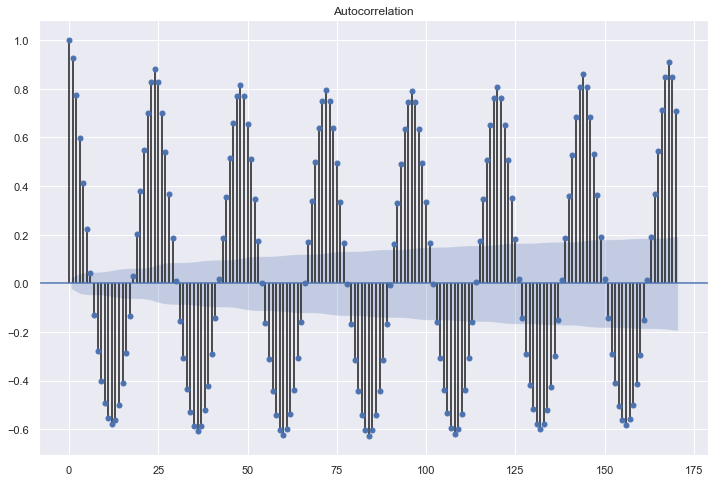

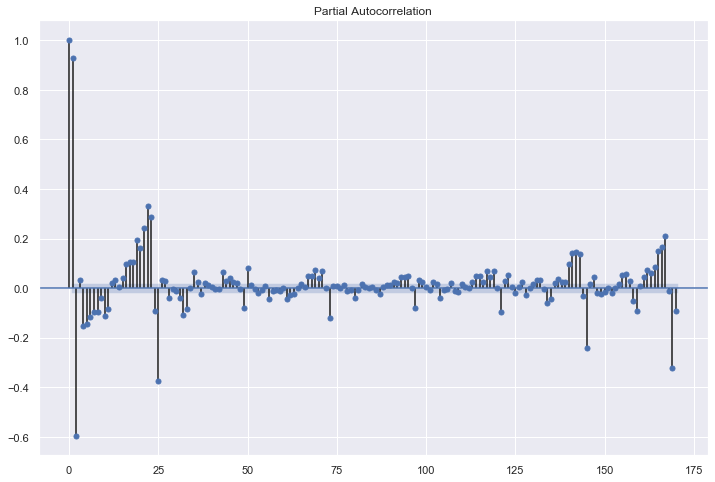

In [38]:
print_plots(df_light, 170)

## Seasonal decompose

/home/pumford/.conda/envs/bridge/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


Text(0.5, 1.03, 'Weekly circulation decomposition, all vehicles')

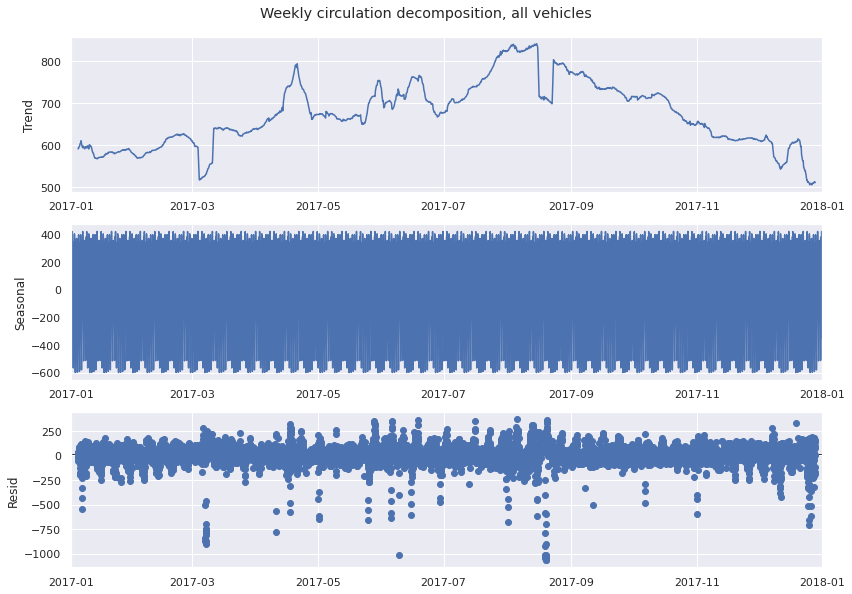

In [43]:
result = seasonal_decompose(df_all, model='additive',freq=168)
fig = result.plot(observed=False)
fig.suptitle('Weekly circulation decomposition, all vehicles', y=1.03)

In [34]:
sq_res = result.resid**2

In [35]:
week_sq = sq_res.sum()

/home/pumford/.conda/envs/bridge/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


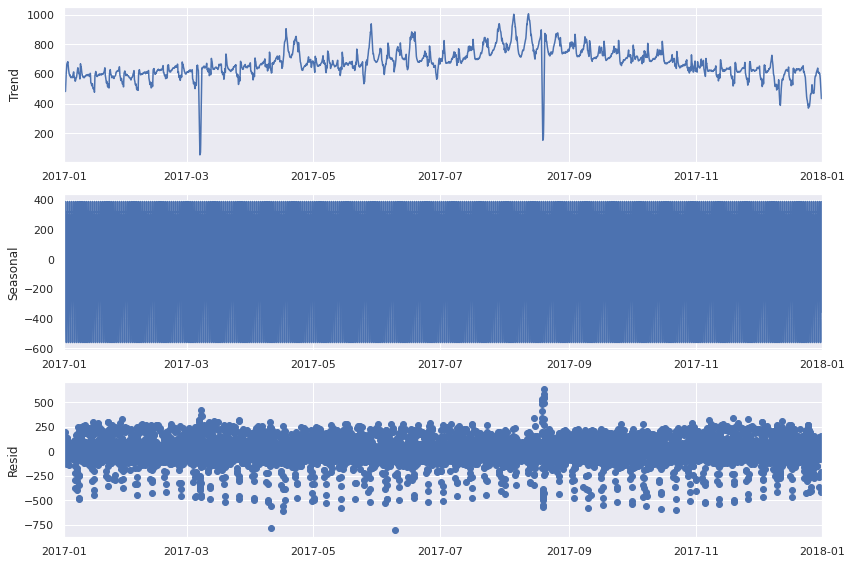

In [36]:
result = seasonal_decompose(df_all, model='additive',freq=24)
fig = result.plot(observed=False)
sq_res = result.resid**2

In [37]:
day_sum = sq_res.sum()

In [41]:
(week_sq/day_sum)**-1

1.3812772209111683

In [32]:
df_try = df_all.reset_index()

In [86]:
sun = df_all[:24]

In [94]:
df_all = pd.concat([df_all[25:], sun])

In [95]:
df_all

2017-01-02 02:00:00    114.0
2017-01-02 03:00:00    126.0
2017-01-02 04:00:00    144.0
2017-01-02 05:00:00    171.0
2017-01-02 06:00:00    387.0
                       ...  
2017-01-01 19:00:00    614.0
2017-01-01 20:00:00    496.0
2017-01-01 21:00:00    449.0
2017-01-01 22:00:00    415.0
2017-01-01 23:00:00    273.0
Name: Date, Length: 8759, dtype: float64

In [97]:
df_try['Hour_week'] = np.remainder(df_try.index,168).astype(int)

In [24]:
df_all

2017-01-01 00:00:00     49.0
2017-01-01 01:00:00    357.0
2017-01-01 02:00:00    379.0
2017-01-01 03:00:00    251.0
2017-01-01 04:00:00    188.0
                       ...  
2017-12-31 20:00:00    337.0
2017-12-31 21:00:00    185.0
2017-12-31 22:00:00    159.0
2017-12-31 23:00:00    153.0
2018-01-01 00:00:00     65.0
Freq: H, Name: Date, Length: 8761, dtype: float64

In [22]:
df_heavy

2017-01-01 00:00:00    0.0
2017-01-01 01:00:00    1.0
2017-01-01 02:00:00    1.0
2017-01-01 03:00:00    1.0
2017-01-01 04:00:00    1.0
                      ... 
2017-12-30 20:00:00    3.0
2017-12-30 21:00:00    1.0
2017-12-30 22:00:00    3.0
2017-12-30 23:00:00    9.0
2017-12-31 00:00:00    3.0
Freq: H, Name: Date, Length: 8737, dtype: float64

/home/pumford/.conda/envs/bridge/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Mean all vehicles per hour per day of week')

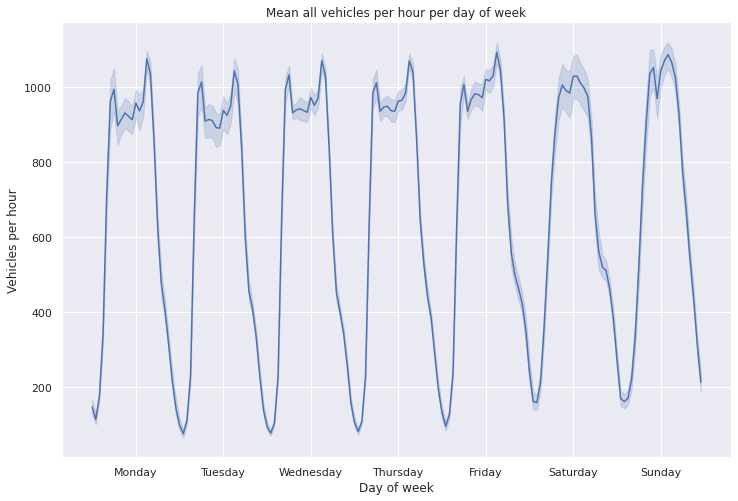

In [102]:
fig, ax = plt.subplots()
sns.lineplot(df_try['Hour_week'], df_try['Date'], legend=False)
day_ticks = np.arange(12, 167, 24)
day_dict={36: "Tuesday", 60: "Wednesday", 84: "Thursday", 108: 'Friday', 132: 'Saturday',
                                                     156: 'Sunday', 12:'Monday'}
ax.set(xticks=day_ticks, xticklabels=map(day_dict.get, day_ticks))
ax.set_xlabel('Day of week')
ax.set_ylabel('Vehicles per hour')
ax.set_title('Mean all vehicles per hour per day of week')

In [103]:
sun = df_heavy[:24]
df_try = pd.concat([df_heavy[25:], sun]).reset_index()

/home/pumford/.conda/envs/bridge/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Mean heavy vehicles per hour per day of week')

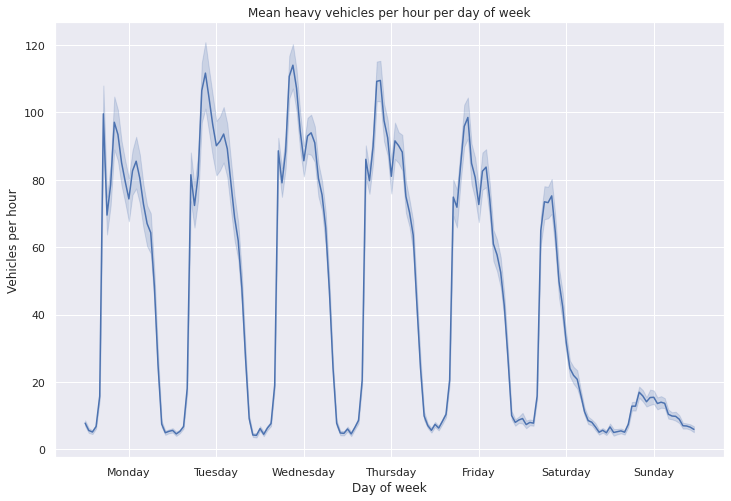

In [105]:
fig, ax = plt.subplots()
df_try['Hour_week'] = np.remainder(df_try.index,168).astype(int)
sns.lineplot(df_try['Hour_week'], df_try['Date'], legend=False)
ax.set(xticks=day_ticks, xticklabels=map(day_dict.get, day_ticks))
ax.set_xlabel('Day of week')
ax.set_ylabel('Vehicles per hour')
ax.set_title('Mean heavy vehicles per hour per day of week')

/home/pumford/.conda/envs/bridge/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Mean light vehicles per hour per day of week')

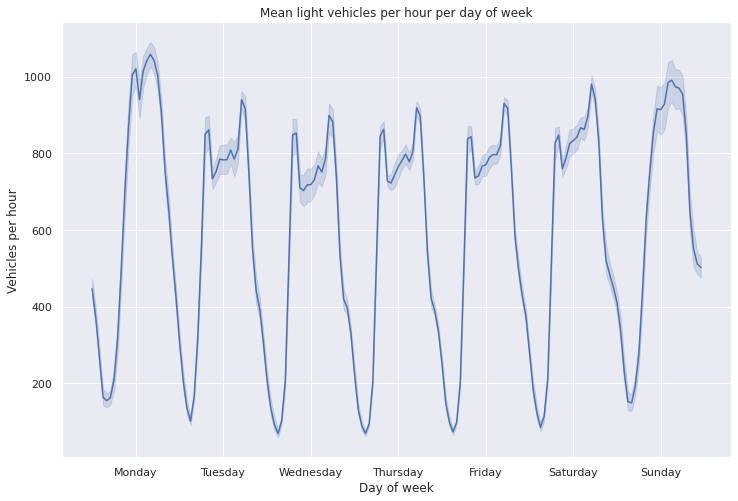

In [107]:
sun = df_light[:24]
df_try = pd.concat([df_light[25:], sun]).reset_index()
fig, ax = plt.subplots()
df_try = df_light.reset_index()
df_try['Hour_week'] = np.remainder(df_try.index,168).astype(int)
sns.lineplot(df_try['Hour_week'], df_try['Date'], legend=False)
ax.set(xticks=day_ticks, xticklabels=map(day_dict.get, day_ticks))
ax.set_xlabel('Day of week')
ax.set_ylabel('Vehicles per hour')
ax.set_title('Mean light vehicles per hour per day of week')

/home/pumford/.conda/envs/bridge/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


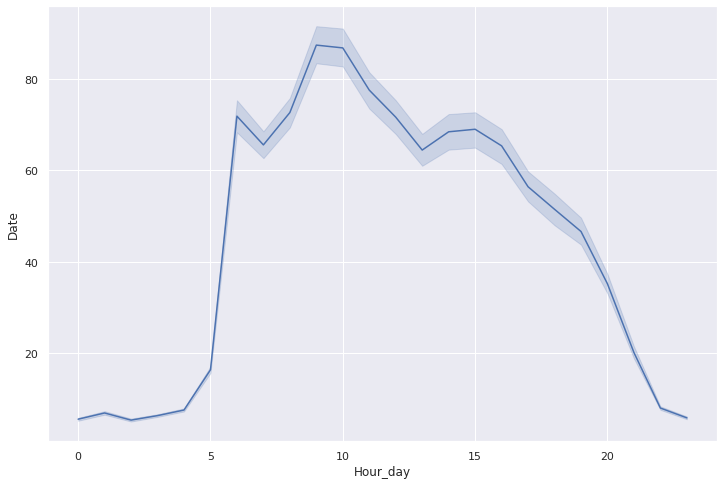

In [113]:
#Trying with 24 hour seasonality
df_try = df_heavy.reset_index()
df_try['Hour_day'] = np.remainder(df_try.index,24).astype(int)
sns.lineplot(df_try['Hour_day'], df_try['Date'], legend=False)


In [131]:
#Looking at holiday patterns
df_try['DoY'] = pd.to_datetime(df_try['index'].dt.date)
cal = Switzerland()
swiss_hol = cal.holidays(2017) + cal.holidays(2018)
hol_dates = []
for date, name in swiss_hol:
    hol_dates.append(date)
df_try['holiday'] = df_try['DoY'].isin(hol_dates)

In [132]:
hol = df_try[df_try.holiday]

In [136]:
hol = hol.reset_index()

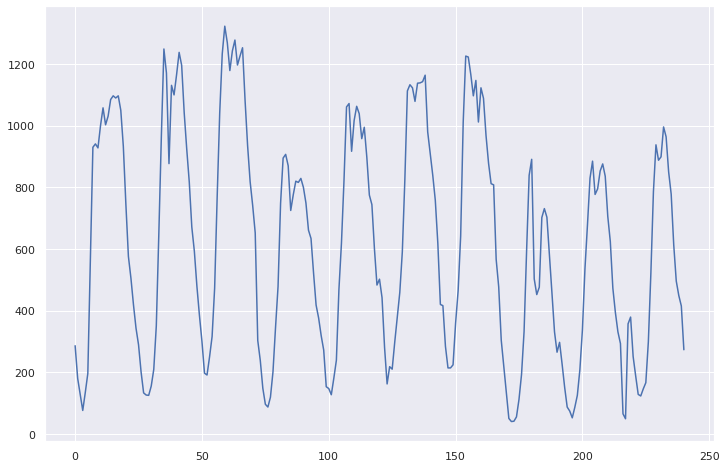

In [137]:
hol['Hour_day'] = np.remainder(hol.index,24).astype(int)
hol.Date.plot()
#sns.lineplot(hol['Hour_day'], hol['Date'], legend=False)

In [141]:
def plot_holiday(df):
    #Looking at holiday patterns
    df = df.reset_index()
    df['DoY'] = pd.to_datetime(df['index'].dt.date)
    cal = Switzerland()
    swiss_hol = cal.holidays(2017) + cal.holidays(2018)
    hol_dates = []
    hol_name = []
    for date, name in swiss_hol:
        hol_dates.append(date)
    df['holiday'] = df['DoY'].isin(hol_dates)
    hol = df[df.holiday]
    hol = hol.reset_index()

    hol['Hour_day'] = np.remainder(hol.index,24).astype(int)
    hol.Date.plot()

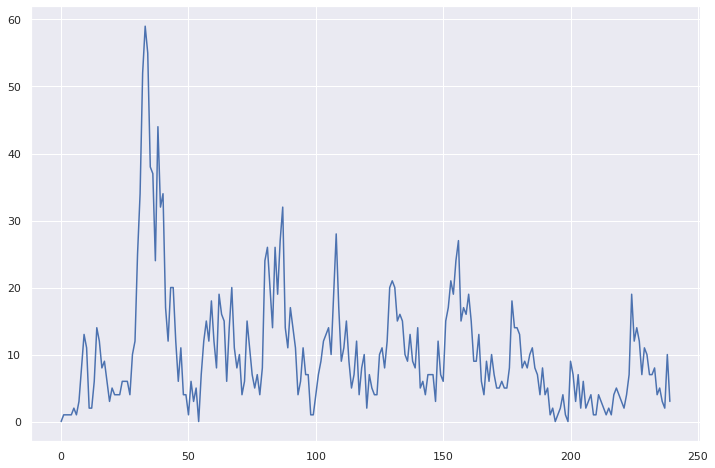

In [142]:
plot_holiday(df_heavy)

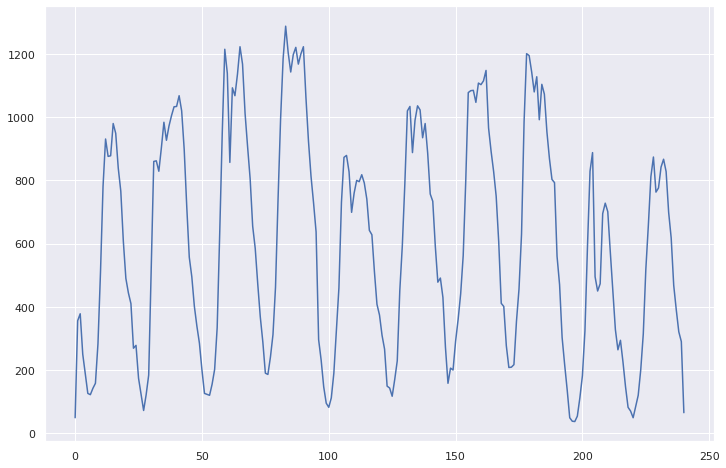

In [143]:
plot_holiday(df_light)

Text(0, 0.5, 'Vehicles per hour')

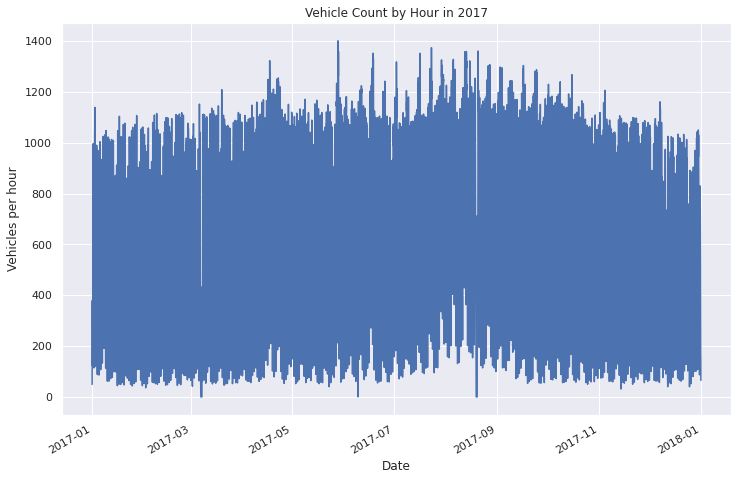

In [146]:
ax = df_all.plot(title="Vehicle Count by Hour in 2017")
ax.set_xlabel("Date")
ax.set_ylabel("Vehicles per hour")

/home/pumford/.conda/envs/bridge/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


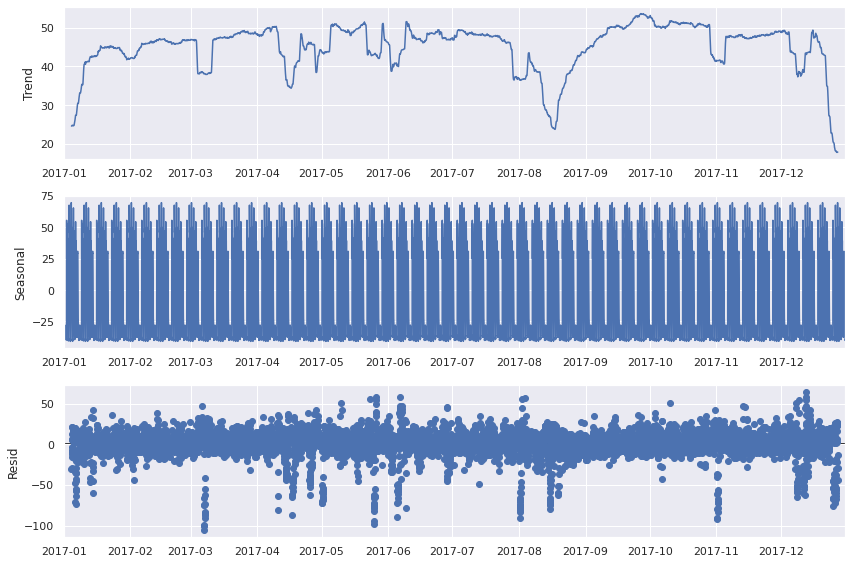

In [148]:
result = seasonal_decompose(df_heavy, model='additive',freq=168)
result.plot(observed=False, )

/home/pumford/.conda/envs/bridge/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


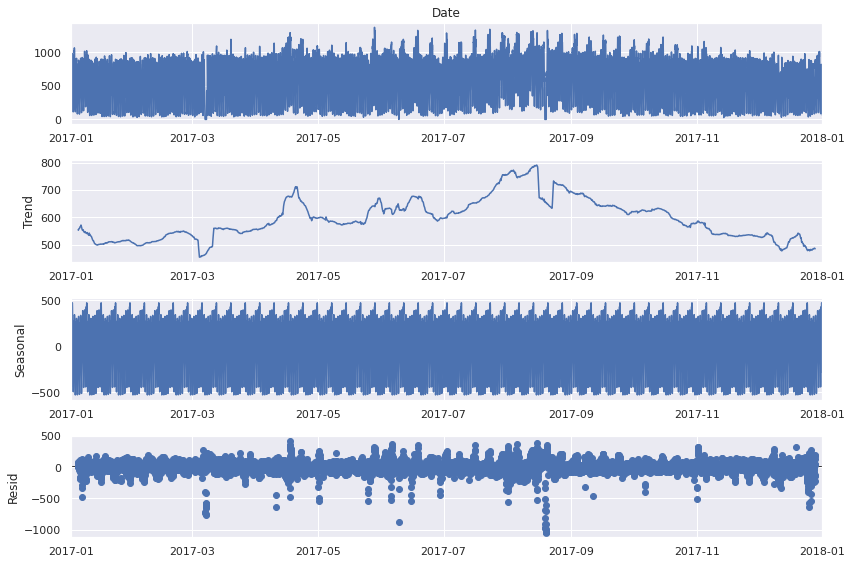

In [112]:
result = seasonal_decompose(df_light, model='additive',freq=168)
fig = result.plot()

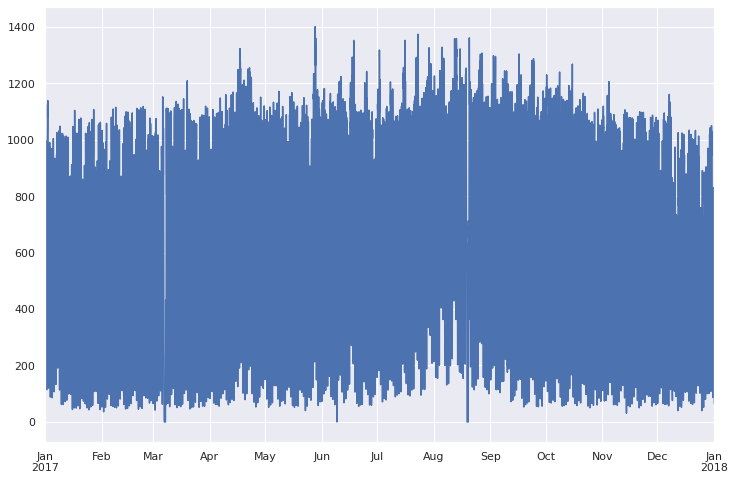

In [23]:
df_all.plot()

In [90]:
#Dickey-Fuller test:
adfTest = adfuller(df_light.diff(168).fillna(0))

pvalue = adfTest[1]

In [91]:
pvalue #Reject the null, it is stationary

3.678282572438139e-26

In [103]:
adfTest

(-14.420154434949513,
 7.93683320756975e-27,
 26,
 8734,
 {'1%': -3.4310989378240957,
  '5%': -2.8618709806843423,
  '10%': -2.5669461760495387},
 103373.52049093234)

In [82]:
from statsmodels.tsa.stattools import kpss


In [87]:
kpss(df_light.diff(168).fillna(0))

/home/pumford/.conda/envs/bridge/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


(0.21583683673554344,
 0.1,
 37,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [95]:
# We can add multiple fourer series with different k terms - (2*k*pi) such as k=1,2,3...etc. To generalize the problem, 
# we could have chosen an optimal k value for each season by trying out some k values and choosing the values giving 
# the lowest AIC score.

def add_fourier_terms(df, year_k, half_day_k, week_k, day_k):
    """
    df: dataframe to add the fourier terms to 
    year_k: the number of Fourier terms the year period should have. Thus the model will be fit on 2*year_k terms (1 term for 
            sine and 1 for cosine)
    week_k: same as year_k but for weekly periods
    day_k:  same as year_k but for daily periods
    """
    
    terms_df =df.copy()
    
    for k in range(1, year_k+1):
        # year has a period of 365.25 including the leap year
        terms_df['year_sin'+str(k)] = np.sin(2 *k* np.pi * terms_df.index.dayofyear/365.25) 
        terms_df['year_cos'+str(k)] = np.cos(2 *k* np.pi * terms_df.index.dayofyear/365.25)

    for k in range(1, half_day_k+1):
        
        # week has a period of 7
        terms_df['half_sin'+str(k)] = np.sin(2 *k* np.pi * terms_df.index.hour/12)
        terms_df['half_cos'+str(k)] = np.cos(2 *k* np.pi * terms_df.index.hour/12)

    for k in range(1, week_k+1):
        
        # week has a period of 7
        terms_df['week_sin'+str(k)] = np.sin(2 *k* np.pi * terms_df.index.dayofweek/7)
        terms_df['week_cos'+str(k)] = np.cos(2 *k* np.pi * terms_df.index.dayofweek/7)

    for k in range(1, day_k+1):
        
        # day has period of 24
        terms_df['hour_sin'+str(k)] = np.sin(2 *k* np.pi * terms_df.index.hour/24)
        terms_df['hour_cos'+str(k)] = np.cos(2 *k* np.pi * terms_df.index.hour/24) 

    terms_df = terms_df.drop(columns='HourCount')
    return terms_df

In [ ]:
def test_fourier_terms(k_day):
    aic_values = []
    k_values =  []
    k_half = 0
    k_week = 0
    k_year = 0
    test_df = add_fourier_terms(df, k_year, k_half, k_week, k_day)
    model = pm.auto_arima(df, D=0, max_P=0, max_Q=0,start_P=0,start_Q=0, stepwise=True, exogenous=test_df)
    aic_values.append(model.aic())
    k_values.append((k_half, k_day, k_week, k_year))
    print("{} half, {} day, {} week, {} year, {} aic".format(k_half, k_day, k_week, k_year, model.aic()))

In [96]:
import pmdarima as pm
#I want to find the optimal fouier orders to include for each of the seasonalities, year, day, week
#to find this I loop through combinations of fourier 
aic_values = []
k_values =  []
k_half = 0
k_week = 0
k_year = 0
for k_day in range(0, 10):
    test_df = add_fourier_terms(df, k_year, k_half, k_week, k_day)
    model = pm.auto_arima(df, D=1, max_P=0, max_Q=0,start_P=0,start_Q=0, stepwise=True, exogenous=test_df)
    aic_values.append(model.aic())
    k_values.append((k_half, k_day, k_week, k_year))
    print("{} half, {} day, {} week, {} year, {} aic".format(k_half, k_day, k_week, k_year, model.aic()))

C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

4 half, 5 day, 4 week, 4 year, 105935.29067621767 aic


C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KeyboardInterrupt: 

In [18]:
test, train = train_test(df_light)

In [57]:
all_test, all_train = train_test(df_all)

In [113]:
# Creating the training and test datasets

# The code below can be used to train and find the optimal SARIMAX model parameters p,q,P,Q. 
#This was run and the optimal model was found to be SARIMAX(2,0,0)x(1,0,0,24). The auto regressive term p=2 means 
#two values from the past (1 and 2 hours behind) will be used and moving average term of q=1 means 1 past term will be used as 
# the moving average term. d=1 term means the energy series will differenced once to make it stationary. 
# Seasonal period m of 24 hours here and P=Q=1 means the auto regressive term (P) and the moving average (Q) exactly 1*24 hours 
# behind will be used.

results = pm.auto_arima(df['Date'], #data
                    d=0, # non-seasonal difference order
                    start_p=1, # initial guess for p
                    start_q=0, # initial guess for q
                    max_p=3, # max value of p to test
                    max_q=2, # max value of q to test
                    exogenous= df.drop(columns='Date'), #including the exogenous variables
                    seasonal=True, # is the time series seasonal? YES
                    m = 168, # the seasonal period
                    D = 1,
                    start_P=1, # initial guess for P
                    start_Q=0, # initial guess for Q
                    max_P=3, # max value of P to test
                    max_Q=2, # max value of Q to test
                    information_criterion='aic', # used to select best model
                    trace=True, # print results whilst training
                    stepwise=True, # apply intelligent order search
                    )


Performing stepwise search to minimize aic


KeyboardInterrupt: 

In [ ]:
_= results.plot_diagnostics(figsize=(12, 7))

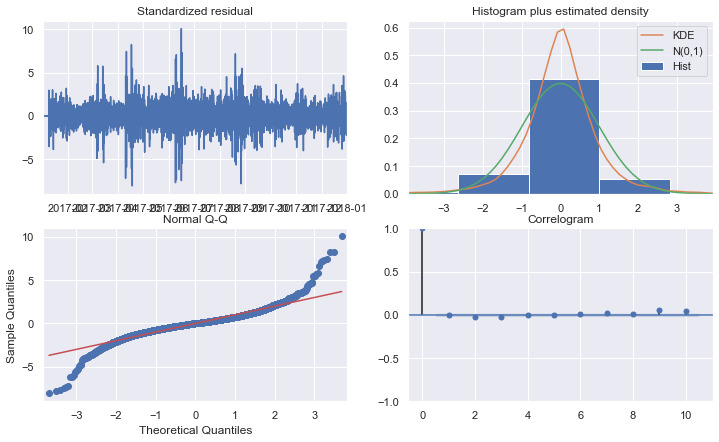

In [81]:
_= results.plot_diagnostics(figsize=(12, 7))

In [102]:
def test_SARIMAX(train, p_, q_, P_, Q_):
    print('Starting test')
    model_opt = ARIMA(train['HourCount'], order=(p_,1,q_), seasonal_order=(P_, 1, Q_, 168), exog = train.drop(columns='HourCount'), trend='c')
    results = model_opt.fit(method='innovations_mle', low_memory=True, cov_type='none')
    print_results = '({}, 1, {})({}, 1, {}), aic={}'.format(p_, q_, P_, Q_, results.aic)
    print(print_results)
    return print_results

In [118]:
def grid_search(df, heavy_light):
    
    test, train = train_test(df)

    executor = Parallel(n_jobs=cpu_count()-5)
    
    q_values = range(0, 2)
    p_values = range(0, 3)
    Q_values = range(0, 2)
    P_values = range(1, 4)

    scores = []
    try:
        tasks = (delayed(test_SARIMAX)(train, p, q, P, Q) for p in p_values for q in q_values for Q in Q_values for P in P_values)
        results = executor(tasks)

        scores.append(results)
    except Exception as e:
        print('Fatal error')
        print(e)
    
    with open('testing_{}.txt'.format(heavy_light), 'w') as f:
        for item in scores:
            f.write("%s\n" % item)

In [119]:
#Test the light in a grid search
grid_search(df_light, 'light')

KeyboardInterrupt: 

In [129]:
#Test the light in a grid search
grid_search(df_heavy, 'heavy')

In [36]:
def best_models(df, heavy_light):
    
    test, train = train_test(df)
    
    if heavy_light == 'light':
        #Best model for the light car traffic: (1, 0, 0)(3, 1, 0), aic=94769.52128285923
        model_opt = ARIMA(train['Date'], order=(1,0,0), seasonal_order=(1, 1, 1, 168), exog = train.drop(columns='Date'), trend='c')
        results = model_opt.fit(method='innovations_mle', low_memory=True, cov_type='none')
    elif heavy_light == 'heavy':
        #Best model for the light car traffic: (1, 0, 0)(3, 1, 0), aic=94769.52128285923
        model_opt = ARIMA(train['Date'], order=(1,0,1), seasonal_order=(1, 1, 1, 168), exog = train.drop(columns='Date'), trend='c')
        results = model_opt.fit(method='innovations_mle', low_memory=True, cov_type='none')
        
    _ = results.plot_diagnostics(figsize=(12, 7))
    
    forecast_1= results.predict(start=test.index[0], end=test.index[-1], exog=test.drop(columns='Date'))
    plt.plot(test['Date'], label='Actual')
    #plt.plot(df_no_week.tail(336))
    plt.plot(forecast_1, color='red', label='Prediction')
    #plt.plot(test['Date']-forecast_1, color='purple', label='Residuals')
    plt.legend()
    plt.title('Two week SARIMAX forecast of hourly {} vehicle traffic at station 137'.format(heavy_light))
    plt.show()
    
    #return forecast_1, results

In [130]:
test, train = train_test(df_light)

#Best model for the light car traffic: (1, 0, 0)(3, 1, 0), aic=94769.52128285923
model_opt = ARIMA(train['HourCount'], order=(2, 1, 1), seasonal_order=(2, 1, 1, 168), exog = train.drop(columns='HourCount'), trend='c')
results = model_opt.fit(method='innovations_mle', low_memory=True, cov_type='none')

/home/pumford/.conda/envs/bridge/lib/python3.7/site-packages/statsmodels/tsa/arima/estimators/gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


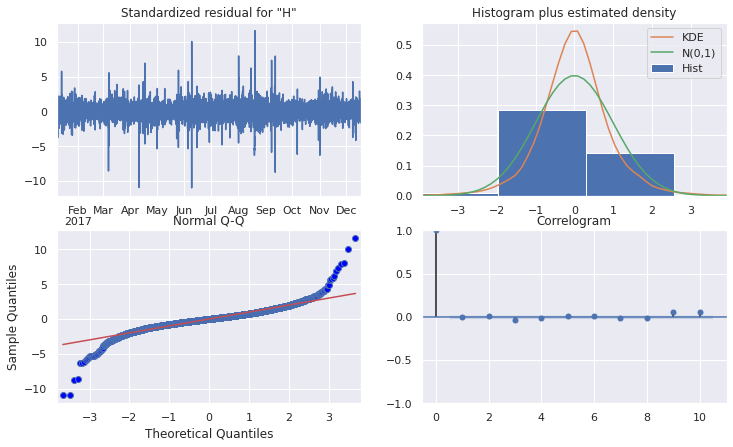

In [131]:
_ = results.plot_diagnostics(figsize=(12, 7))


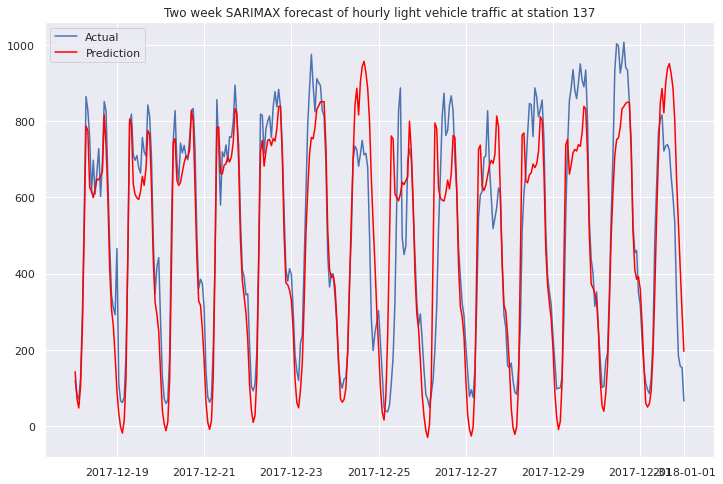

In [132]:
forecast_1= results.predict(start=test.index[0], end=test.index[-1], exog=test.drop(columns='HourCount'))
plt.plot(test['HourCount'], label='Actual')
#plt.plot(df_no_week.tail(336))
plt.plot(forecast_1, color='red', label='Prediction')
#plt.plot(test['Date']-forecast_1, color='purple', label='Residuals')
plt.legend()
plt.title('Two week SARIMAX forecast of hourly {} vehicle traffic at station 137'.format('light'))
plt.show()

In [133]:
mape_score = (abs(test['HourCount']-forecast_1)/test['HourCount'])*100
mape_score.mean()

36.52668258898553

In [134]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         HourCount   No. Observations:                 8425
Model:             ARIMA(2, 1, 1)x(2, 1, 1, 168)   Log Likelihood              -44994.100
Date:                           Tue, 05 Jan 2021   AIC                          90046.199
Time:                                   08:17:01   BIC                          90249.742
Sample:                               01-01-2017   HQIC                         90115.759
                                    - 12-18-2017                                         
Covariance Type:                    Not computed                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const               0        nan        nan        nan         nan         nan
holiday        3.0553        nan        nan        nan         nan         nan
hour_sin1           0        nan        nan        nan         nan         nan
hour_cos1           0        nan        nan        nan         nan         nan
hour_sin2           0        nan        nan        nan         nan         nan
hour_cos2           0        nan        nan        nan         nan         nan
hour_sin3           0        nan        nan        nan         nan         nan
hour_cos3           0        nan        nan        nan         nan         nan
hour_sin4           0        nan        nan        nan         nan         nan
hour_cos4           0        nan        nan        nan         nan         nan
hour_sin5           0        nan        nan        nan         nan         nan
hour_cos5           0        nan        nan        nan         nan         nan
hour_sin6           0        nan        nan        nan         nan         nan
hour_cos6           0        nan        nan        nan         nan         nan
hour_sin7           0        nan        nan        nan         nan         nan
hour_cos7           0        nan        nan        nan         nan         nan
hour_sin8           0        nan        nan        nan         nan         nan
hour_cos8           0        nan        nan        nan         nan         nan
hour_sin9           0        nan        nan        nan         nan         nan
hour_cos9           0        nan        nan        nan         nan         nan
hour_sin10          0        nan        nan        nan         nan         nan
hour_cos10          0        nan        nan        nan         nan         nan
ar.L1          0.8342        nan        nan        nan         nan         nan
ar.L2         -0.0306        nan        nan        nan         nan         nan
ma.L1         -0.9910        nan        nan        nan         nan         nan
ar.S.L168      0.1039        nan        nan        nan         nan         nan
ar.S.L336      0.1051        nan        nan        nan         nan         nan
ma.S.L168     -0.9140        nan        nan        nan         nan         nan
sigma2      3078.9779        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             59483.66
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.14
===================================================================================

Warnings:
[1] Covariance matrix not calculated.
"""

In [135]:
old_for = pd.read_pickle('Models/Ceneri_lane5_light.pkl')

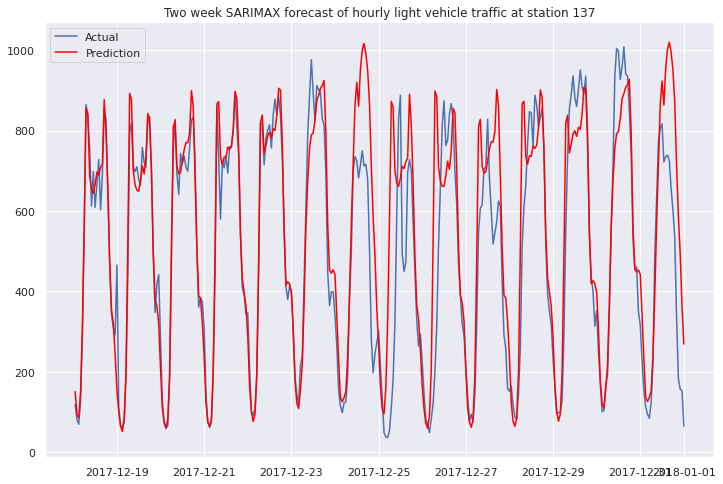

In [136]:
plt.plot(test['HourCount'], label='Actual')
#plt.plot(df_no_week.tail(336))
plt.plot(old_for, color='red', label='Prediction')
#plt.plot(test['Date']-forecast_1, color='purple', label='Residuals')
plt.legend()
plt.title('Two week SARIMAX forecast of hourly {} vehicle traffic at station 137'.format('light'))
plt.show()

In [137]:
mape_score = (abs(test['HourCount']-old_for)/test['HourCount'])*100
mape_score.mean()

32.26329247028043

In [25]:
#Save the forecast and the model
forecast_1.to_pickle('Models/Ceneri_lane5_light.pkl')

In [26]:
results.save('Models/Ceneri_lane5_light_sarimax_model.pkl')

In [17]:
test, train = train_test(df_heavy)


#Best model for the light car traffic: (1, 0, 0)(3, 1, 0), aic=94769.52128285923
model_opt = ARIMA(train['HourCount'], order=(1,0,1), seasonal_order=(1, 1, 1, 168), exog = train.drop(columns='HourCount'), trend='c')
results = model_opt.fit(method='innovations_mle', low_memory=True, cov_type='none')

/home/pumford/.conda/envs/bridge/lib/python3.7/site-packages/statsmodels/tsa/arima/estimators/gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


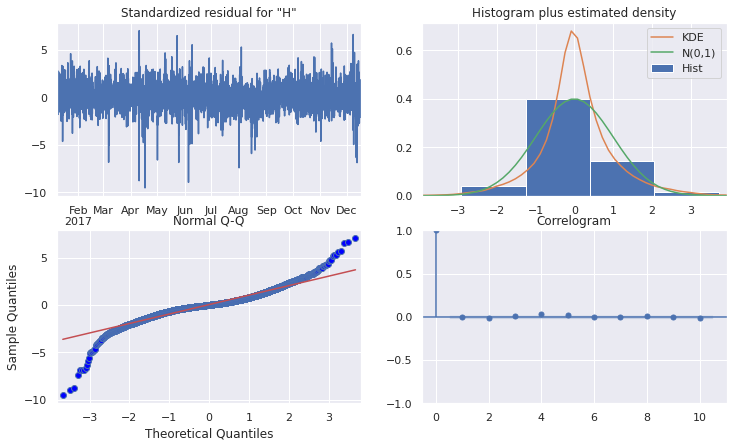

In [21]:
_ = results.plot_diagnostics(figsize=(12, 7))


In [22]:
forecast_1= results.predict(start=test.index[0], end=test.index[-1], exog=test.drop(columns='HourCount'))
forecast_1 = forecast_1.apply(lambda x: x if x > 0 else 0)

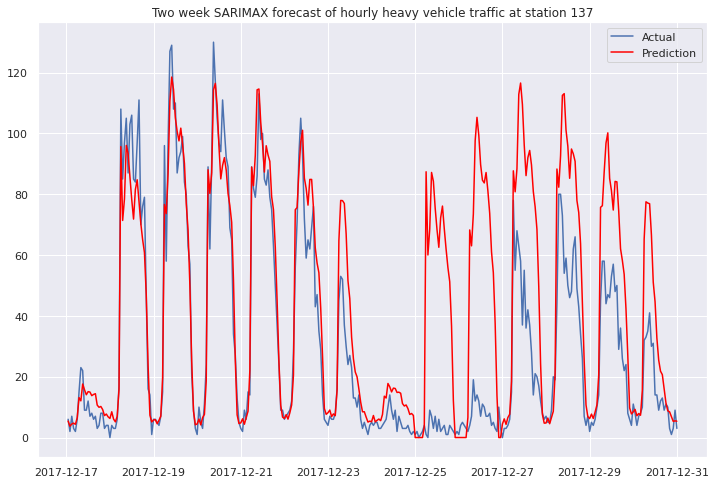

In [23]:
plt.plot(test['HourCount'], label='Actual')
#plt.plot(df_no_week.tail(336))
plt.plot(forecast_1, color='red', label='Prediction')
#plt.plot(test['Date']-forecast_1, color='purple', label='Residuals')
plt.legend()
plt.title('Two week SARIMAX forecast of hourly {} vehicle traffic at station 137'.format('heavy'))
plt.show()

In [24]:
mape_score = (abs(test['HourCount']-forecast_1)/test['HourCount'])*100
mape_score.mean()

inf

In [25]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         HourCount   No. Observations:                 8401
Model:             ARIMA(1, 0, 1)x(1, 1, 1, 168)   Log Likelihood              -30969.732
Date:                           Fri, 11 Dec 2020   AIC                          61993.464
Time:                                   07:50:18   BIC                          62182.893
Sample:                               01-01-2017   HQIC                         62058.209
                                    - 12-17-2017                                         
Covariance Type:                    Not computed                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const               0        nan        nan        nan         nan         nan
holiday      -12.6493        nan        nan        nan         nan         nan
hour_sin1           0        nan        nan        nan         nan         nan
hour_cos1           0        nan        nan        nan         nan         nan
hour_sin2           0        nan        nan        nan         nan         nan
hour_cos2           0        nan        nan        nan         nan         nan
hour_sin3           0        nan        nan        nan         nan         nan
hour_cos3           0        nan        nan        nan         nan         nan
hour_sin4           0        nan        nan        nan         nan         nan
hour_cos4           0        nan        nan        nan         nan         nan
hour_sin5           0        nan        nan        nan         nan         nan
hour_cos5           0        nan        nan        nan         nan         nan
hour_sin6           0        nan        nan        nan         nan         nan
hour_cos6           0        nan        nan        nan         nan         nan
hour_sin7           0        nan        nan        nan         nan         nan
hour_cos7           0        nan        nan        nan         nan         nan
hour_sin8           0        nan        nan        nan         nan         nan
hour_cos8           0        nan        nan        nan         nan         nan
hour_sin9           0        nan        nan        nan         nan         nan
hour_cos9           0        nan        nan        nan         nan         nan
hour_sin10          0        nan        nan        nan         nan         nan
hour_cos10          0        nan        nan        nan         nan         nan
ar.L1          0.8865        nan        nan        nan         nan         nan
ma.L1         -0.3912        nan        nan        nan         nan         nan
ar.S.L168      0.0715        nan        nan        nan         nan         nan
ma.S.L168     -0.9550        nan        nan        nan         nan         nan
sigma2       103.4087        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             18765.39
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.38
===================================================================================

Warnings:
[1] Covariance matrix not calculated.
"""

In [26]:
#Save the forecast and the model
forecast_1.to_pickle('Models/Ceneri_lane5_heavy.pkl')

results.save('Models/Ceneri_lane5_heavy_sarimax_model.pkl')

C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:134: UserWarning: Provided `endog` and `exog` series have been differenced to eliminate integration prior to GLS parameter estimation.
  warnings.warn('Provided `endog` and `exog` series have been'


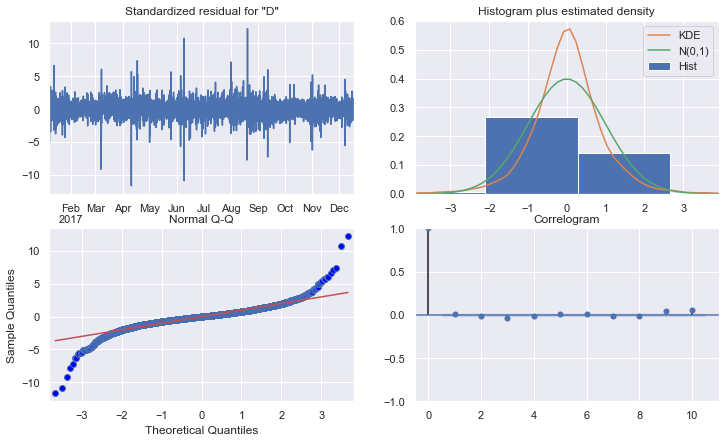

In [52]:
#Best model for the light car traffic: (1, 0, 0)(3, 1, 0), aic=94769.52128285923
model_opt = ARIMA(train['Date'], order=(1,0,0), seasonal_order=(3, 1, 0, 168), exog = train.drop(columns='Date'), trend='c')
results = model_opt.fit(method='innovations_mle', low_memory=True, cov_type='none')
_ = results.plot_diagnostics(figsize=(12, 7))

C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


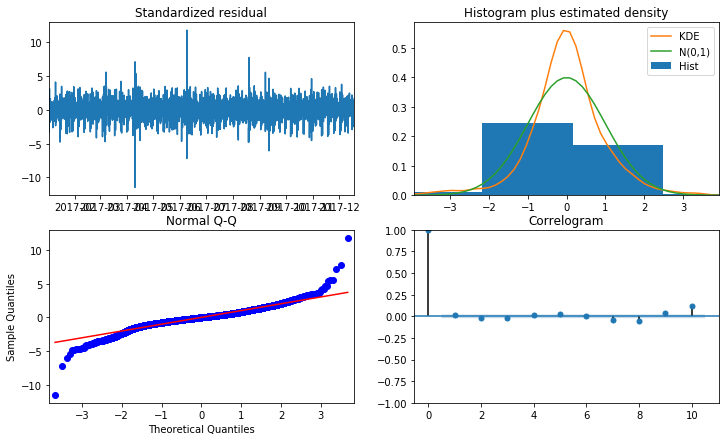

In [38]:
#results.fit(y_train_lag, exogenous= X_train_lag)
# Got the optimal SARIMAX order from running the above auto_arima function. It took more than 2 hours to get the optimal...
#...solution. So, just using the final values here
model_opt = SARIMAX(train['Date'], order=(2,0,0), seasonal_order=(2, 1, 0, 168), exog = train.drop(columns='Date'), trend='c')
results = model_opt.fit()
# plotting the residuals and checking if they meet the i.i.d (independent and identically distributed) requirements
_ = results.plot_diagnostics(figsize=(12, 7))

In [48]:
results.save('Models/SAIMAX_all_inner_lane.pkl')

In [40]:
residuals = pd.DataFrame(results.resid)

In [53]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              Date   No. Observations:                 8425
Model:             ARIMA(1, 0, 0)x(3, 1, 0, 168)   Log Likelihood              -47361.761
Date:                           Thu, 03 Dec 2020   AIC                          94757.521
Time:                                   09:42:56   BIC                          94876.841
Sample:                               01-01-2017   HQIC                         94798.298
                                    - 12-18-2017                                         
Covariance Type:                    Not computed                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const               0        nan        nan        nan         nan         nan
hour_sin1           0        nan        nan        nan         nan         nan
hour_cos1           0        nan        nan        nan         nan         nan
hour_sin2           0        nan        nan        nan         nan         nan
hour_cos2           0        nan        nan        nan         nan         nan
hour_sin3           0        nan        nan        nan         nan         nan
hour_cos3           0        nan        nan        nan         nan         nan
hour_sin4           0        nan        nan        nan         nan         nan
hour_cos4           0        nan        nan        nan         nan         nan
hour_sin5           0        nan        nan        nan         nan         nan
hour_cos5           0        nan        nan        nan         nan         nan
holiday             0        nan        nan        nan         nan         nan
ar.L1          0.8545        nan        nan        nan         nan         nan
ar.S.L168     -0.6967        nan        nan        nan         nan         nan
ar.S.L336     -0.3903        nan        nan        nan         nan         nan
ar.S.L504     -0.1856        nan        nan        nan         nan         nan
sigma2      5561.5164        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):             68314.73
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.09
===================================================================================

Warnings:
[1] Covariance matrix not calculated.
"""

In [73]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                Date   No. Observations:                 8425
Model:             ARIMA(2, 0, 0)x(3, 1, [1], 168)   Log Likelihood              -47560.612
Date:                             Wed, 02 Dec 2020   AIC                          95171.223
Time:                                     18:35:07   BIC                          95346.694
Sample:                                 01-01-2017   HQIC                         95231.189
                                      - 12-18-2017                                         
Covariance Type:                      Not computed                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const               0        nan        nan        nan         nan         nan
week_sin1           0        nan        nan        nan         nan         nan
week_cos1           0        nan        nan        nan         nan         nan
week_sin2           0        nan        nan        nan         nan         nan
week_cos2           0        nan        nan        nan         nan         nan
week_sin3           0        nan        nan        nan         nan         nan
week_cos3           0        nan        nan        nan         nan         nan
hour_sin1           0        nan        nan        nan         nan         nan
hour_cos1           0        nan        nan        nan         nan         nan
hour_sin2           0        nan        nan        nan         nan         nan
hour_cos2           0        nan        nan        nan         nan         nan
hour_sin3           0        nan        nan        nan         nan         nan
hour_cos3           0        nan        nan        nan         nan         nan
hour_sin4           0        nan        nan        nan         nan         nan
hour_cos4           0        nan        nan        nan         nan         nan
hour_sin5           0        nan        nan        nan         nan         nan
hour_cos5           0        nan        nan        nan         nan         nan
holiday             0        nan        nan        nan         nan         nan
ar.L1          0.9016        nan        nan        nan         nan         nan
ar.L2         -0.0295        nan        nan        nan         nan         nan
ar.S.L168      0.1632        nan        nan        nan         nan         nan
ar.S.L336      0.1873        nan        nan        nan         nan         nan
ar.S.L504      0.0870        nan        nan        nan         nan         nan
ma.S.L168     -0.9991        nan        nan        nan         nan         nan
sigma2      5535.7143        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):            204491.22
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.37
===================================================================================

Warnings:
[1] Covariance matrix not calculated.
"""

In [40]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              Date   No. Observations:                 8425
Model:             ARIMA(1, 0, 0)x(3, 1, 0, 168)   Log Likelihood              -47361.761
Date:                           Wed, 02 Dec 2020   AIC                          94769.521
Time:                                   09:37:55   BIC                          94930.954
Sample:                               01-01-2017   HQIC                         94824.690
                                    - 12-18-2017                                         
Covariance Type:                    Not computed                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const               0        nan        nan        nan         nan         nan
week_sin1           0        nan        nan        nan         nan         nan
week_cos1           0        nan        nan        nan         nan         nan
week_sin2           0        nan        nan        nan         nan         nan
week_cos2           0        nan        nan        nan         nan         nan
week_sin3           0        nan        nan        nan         nan         nan
week_cos3           0        nan        nan        nan         nan         nan
hour_sin1           0        nan        nan        nan         nan         nan
hour_cos1           0        nan        nan        nan         nan         nan
hour_sin2           0        nan        nan        nan         nan         nan
hour_cos2           0        nan        nan        nan         nan         nan
hour_sin3           0        nan        nan        nan         nan         nan
hour_cos3           0        nan        nan        nan         nan         nan
hour_sin4           0        nan        nan        nan         nan         nan
hour_cos4           0        nan        nan        nan         nan         nan
hour_sin5           0        nan        nan        nan         nan         nan
hour_cos5           0        nan        nan        nan         nan         nan
holiday             0        nan        nan        nan         nan         nan
ar.L1          0.8545        nan        nan        nan         nan         nan
ar.S.L168     -0.6967        nan        nan        nan         nan         nan
ar.S.L336     -0.3903        nan        nan        nan         nan         nan
ar.S.L504     -0.1856        nan        nan        nan         nan         nan
sigma2      5561.5164        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):             68314.73
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.09
===================================================================================

Warnings:
[1] Covariance matrix not calculated.
"""

In [39]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               Date   No. Observations:                 8425
Model:             SARIMAX(2, 0, 0)x(3, 1, 0, 24)   Log Likelihood              -50924.949
Date:                            Tue, 01 Dec 2020   AIC                         101897.898
Time:                                    15:55:42   BIC                         102066.764
Sample:                                01-01-2017   HQIC                        101955.557
                                     - 12-18-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2196      1.224      0.179      0.858      -2.179       2.619
week_sin1    -19.7413      6.112     -3.230      0.001     -31.720      -7.762
week_cos1    -14.8497      5.833     -2.546      0.011     -26.283      -3.417
week_sin2      0.7541      4.776      0.158      0.875      -8.606      10.114
week_cos2      4.1355      4.869      0.849      0.396      -5.408      13.679
week_sin3      1.0778      3.311      0.326      0.745      -5.412       7.568
week_cos3      3.8881      3.138      1.239      0.215      -2.263      10.039
hour_sin1      0.0180   1966.715   9.13e-06      1.000   -3854.673    3854.709
hour_cos1     -0.0338   1945.265  -1.74e-05      1.000   -3812.684    3812.616
hour_sin2     -0.0100   2276.592   -4.4e-06      1.000   -4462.048    4462.028
hour_cos2     -0.0165   2973.676  -5.53e-06      1.000   -5828.314    5828.281
hour_sin3      0.0077   2729.268   2.83e-06      1.000   -5349.259    5349.275
hour_cos3      0.0152   4003.789    3.8e-06      1.000   -7847.266    7847.297
hour_sin4      0.0101   3976.284   2.53e-06      1.000   -7793.362    7793.383
hour_cos4      0.0066   4473.002   1.48e-06      1.000   -8766.917    8766.930
hour_sin5     -0.0036   5245.092  -6.89e-07      1.000   -1.03e+04    1.03e+04
hour_cos5      0.0069   5463.510   1.27e-06      1.000   -1.07e+04    1.07e+04
holiday             0    146.379          0      1.000    -286.898     286.898
ar.L1          1.1246      0.005    204.876      0.000       1.114       1.135
ar.L2         -0.3419      0.006    -56.683      0.000      -0.354      -0.330
ar.S.L24      -0.5023      0.006    -80.225      0.000      -0.515      -0.490
ar.S.L48      -0.3724      0.008    -46.508      0.000      -0.388      -0.357
ar.S.L72      -0.2238      0.008    -28.953      0.000      -0.239      -0.209
sigma2      1.061e+04     76.317    139.083      0.000    1.05e+04    1.08e+04
===================================================================================
Ljung-Box (Q):                      528.15   Jarque-Bera (JB):             21331.21
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.12e+19. Standard errors may be unstable.
"""

In [54]:
#Now want to make predictions

forecast_1= results.predict(start=test.index[0], end=test.index[-1], exog=test.drop(columns='Date'))

In [47]:
forecast_1

2017-12-18 01:00:00    211.560005
2017-12-18 02:00:00    112.199966
2017-12-18 03:00:00     87.302840
2017-12-18 04:00:00     89.513163
2017-12-18 05:00:00    179.158091
                          ...    
2017-12-31 20:00:00    832.137926
2017-12-31 21:00:00    614.685706
2017-12-31 22:00:00    534.443528
2017-12-31 23:00:00    504.826537
2018-01-01 00:00:00    450.630364
Freq: H, Length: 336, dtype: float64

In [46]:
test['Date']

2017-12-18 01:00:00    154.0
2017-12-18 02:00:00     97.0
2017-12-18 03:00:00    103.0
2017-12-18 04:00:00    167.0
2017-12-18 05:00:00    398.0
                       ...  
2017-12-31 20:00:00    496.0
2017-12-31 21:00:00    276.0
2017-12-31 22:00:00    243.0
2017-12-31 23:00:00    216.0
2018-01-01 00:00:00     85.0
Freq: H, Name: Date, Length: 336, dtype: float64

In [111]:
#Convert forcast back to actual data, undo the differencing from the week data
bef_diff = df_no_week.tail(336)
fore_con = np.r_[bef_diff, forecast_1].cumsum().astype(float)

In [114]:
bef_diff

2017-12-18 01:00:00   -129.0
2017-12-18 02:00:00    -57.0
2017-12-18 03:00:00    -49.0
2017-12-18 04:00:00    -41.0
2017-12-18 05:00:00     36.0
                       ...  
2017-12-31 20:00:00     93.0
2017-12-31 21:00:00      2.0
2017-12-31 22:00:00    -97.0
2017-12-31 23:00:00   -204.0
2018-01-01 00:00:00   -347.0
Freq: H, Name: Date, Length: 336, dtype: float64

In [46]:
pm.arima.ndiffs(df_nan.diff().fillna(0))

0

In [138]:
df_no_week = df_nan.diff(168)

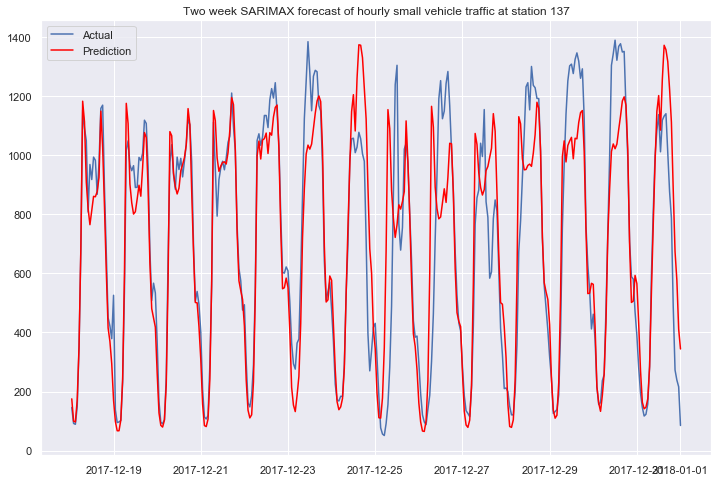

In [55]:
plt.plot(test['Date'], label='Actual')
#plt.plot(df_no_week.tail(336))
plt.plot(forecast_1, color='red', label='Prediction')
#plt.plot(test['Date']-forecast_1, color='purple', label='Residuals')
plt.legend()
plt.title('Two week SARIMAX forecast of hourly small vehicle traffic at station 137')
plt.show()

In [43]:
mape_score = (abs(test['Date']-forecast_1)/test['Date'])*100
mape_mean = mape_score.mean()

In [44]:
mape_mean

28.062170841324296

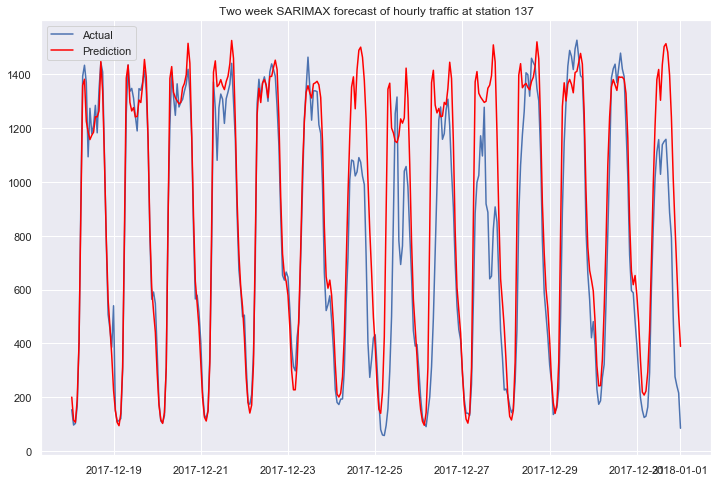

In [75]:
plt.plot(test['Date'], label='Actual')
#plt.plot(df_no_week.tail(336))
plt.plot(forecast_1, color='red', label='Prediction')
plt.legend()
plt.title('Two week SARIMAX forecast of hourly traffic at station 137')
plt.show()

In [76]:
mape_score = (abs(test['Date']-forecast_1)/test['Date'])*100
mape_score.mean()

33.49121284773993

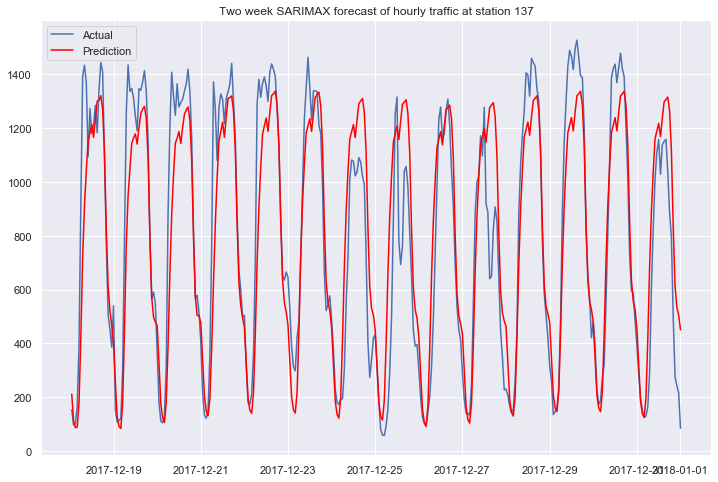

In [43]:
plt.plot(test['Date'], label='Actual')
#plt.plot(df_no_week.tail(336))
plt.plot(forecast_1, color='red', label='Prediction')
plt.legend()
plt.title('Two week SARIMAX forecast of hourly traffic at station 137')
plt.show()

In [44]:
mape_score = (abs(test['Date']-forecast_1)/test['Date'])*100
mape_mean = mape_score.mean()

In [45]:
mape_mean

28.09343248209575

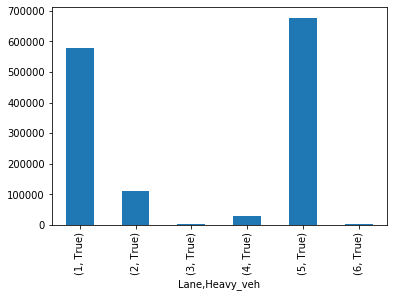

In [33]:
df_heavy.plot.bar()

In [24]:
plt.show()

In [3]:
WIMstation = "Ceneri"
start_year = 2011
end_year = 2019

In [12]:
df_WIM = pd.read_pickle('{}Data/{}_{}_datetime.pkl'.format(WIMstation, start_year, end_year))

In [13]:
df_WIM.head()

,FS,GW_TOT,CLASS,ZST,LENTH,CS,Date
0,4,3500,0,408,674,5,2011-01-01 00:54:14
1,4,5270,0,408,839,8,2011-01-01 00:54:48
2,4,19280,12,408,1429,10,2011-01-01 02:43:02
3,4,4400,0,408,742,5,2011-01-01 02:54:33
4,4,4090,0,408,819,8,2011-01-01 03:12:30


In [14]:
df_WIM = df_WIM[df_WIM.Date.dt.year == 2017]

In [15]:
df_WIM.head()

,FS,GW_TOT,CLASS,ZST,LENTH,CS,Date
9160343,4,3570,0,408,1066,6,2017-01-01 00:28:57
9160344,3,3550,0,408,450,3,2017-01-01 00:52:52
9160345,3,4360,0,408,462,3,2017-01-01 01:20:47
9160346,4,19990,12,408,1434,10,2017-01-01 01:22:18
9160347,3,3550,0,408,423,3,2017-01-01 02:02:02


In [16]:
df_WIM = df_WIM.groupby('FS').Date.count()

In [17]:
df_WIM.head()

FS
1    654315
2     87325
3    115829
4    769014
Name: Date, dtype: int64

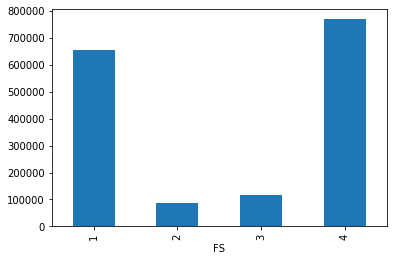

In [18]:
df_WIM.plot.bar()

Based on the above graph and the graph from the lanes in the circulation data, it can be seen that based on the number of heavy vehicles in 2017 at Ceneri passing by lane, that: circ lane 1 is WIM lane 1, circ lane 5 is WIM lane 4. Because these are the inner most lanes they are the ones that will be focused on.

Now looking at these inner two lanes, I will find the car rate per hour.

In [23]:
df_light = df[~df['Heavy_veh']]

In [24]:
inner_lanes = [1, 5] #As states above, these were found to be the inner lanes

In [26]:
df_inner = df_light[df_light.Lane.isin(inner_lanes)]